In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

###DATASET PREP###

In [11]:
trainPath = r".\testIm"
trainPathList = []
trainLabelList = []
trainDirList = os.listdir(trainPath)[:3]
for idx, x in enumerate(trainDirList):
    for xx in os.listdir(f"{trainPath}/{x}"):
        trainPathList.append(f"{trainPath}/{x}/{xx}")
        trainLabelList.append(idx)
        
valPath = r".\ValidationSet"
valPathList = []
valLabelList = []
valDirList = os.listdir(valPath)[:3]
for idx, x in enumerate(valDirList):
    for xx in os.listdir(f"{valPath}/{x}"):
        valPathList.append(f"{valPath}/{x}/{xx}")
        valLabelList.append(idx)

In [13]:
for idx,x in enumerate(valDirList):
    print(idx)
    print(f"{x}: {len(os.listdir(f'{valPath}/{x}'))}")

0
normal: 10
1
osteopenia: 10
2
osteoporosis: 10


In [12]:
trainPathList

['.\\testIm/normal/N10.jpg',
 '.\\testIm/normal/N100.jpg',
 '.\\testIm/normal/N101.jpg',
 '.\\testIm/normal/N11.jpg',
 '.\\testIm/normal/N110.jpg',
 '.\\testIm/normal/N111.jpg',
 '.\\testIm/normal/N120.jpg',
 '.\\testIm/normal/N121.jpg',
 '.\\testIm/normal/N130.jpg',
 '.\\testIm/normal/N131.jpg',
 '.\\testIm/normal/N140.jpg',
 '.\\testIm/normal/N141.jpg',
 '.\\testIm/normal/N150.jpg',
 '.\\testIm/normal/N151.jpg',
 '.\\testIm/normal/N170.jpg',
 '.\\testIm/normal/N171.jpg',
 '.\\testIm/normal/N180.jpg',
 '.\\testIm/normal/N190.jpg',
 '.\\testIm/normal/N191.jpg',
 '.\\testIm/normal/N20.jpg',
 '.\\testIm/normal/N200.jpg',
 '.\\testIm/normal/N201.jpg',
 '.\\testIm/normal/N210.jpg',
 '.\\testIm/normal/N211.jpg',
 '.\\testIm/normal/N230.jpg',
 '.\\testIm/normal/N231.jpg',
 '.\\testIm/normal/N240.jpg',
 '.\\testIm/normal/N250.jpg',
 '.\\testIm/normal/N260.jpg',
 '.\\testIm/normal/N270.jpg',
 '.\\testIm/normal/N290.jpg',
 '.\\testIm/normal/N30.jpg',
 '.\\testIm/normal/N300.jpg',
 '.\\testIm/no

In [15]:
from PIL import Image
imageSizes = {}
for x in valPathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(2180, 2660)': 1,
 '(1024, 1024)': 1,
 '(2430, 1994)': 23,
 '(2386, 1994)': 1,
 '(1994, 2430)': 1,
 '(2430, 1910)': 1,
 '(2402, 1994)': 1,
 '(2378, 1994)': 1}

In [16]:
import torchvision
import torch
import torchvision.transforms.functional as vF

class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None, std = False, mean = False): #mean on if mean needs to be scaled, same goes for std
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform
        self.std = std
        self.mean = mean

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        image = Image.open(self.itemsPath[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        return image, self.labels[idx], self.itemsPath[idx]          
    
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((224,224)),
                                            # torchvision.transforms.CenterCrop((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                           

In [17]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

#inits dataset and dataloader + resamples training data to balance classes
osteoDataset = OsteoTorchDataset(trainPathList,trainLabelList,transform,std=False,mean=False)      
train,val = torch.utils.data.random_split(osteoDataset,[0.8,0.2])#MAY BUG
trainLabels = [y for x,y,z in train]
unique_elements, counts = torch.unique(torch.tensor(trainLabels), return_counts=True)
sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
# MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabels],num_samples=len(train),replacement=True)

trainLoader = DataLoader(train, batch_size = 8,shuffle=False,num_workers=0,sampler=trainSampler)
valLoader = DataLoader(val, batch_size = 16,shuffle=True,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([x for y,x,z in trainLoader]), return_counts=True)#delete this
counts

tensor([ 86,  89, 106])

In [7]:
unique_elements, counts = torch.unique(torch.cat([x for y,x,z in valLoader]), return_counts=True)#delete this
counts

tensor([12, 42, 16])

In [8]:
temp = next(iter(trainLoader))
temp[0][0].max()
index = -1

225
C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\testIm/osteopenia/OP530.jpg


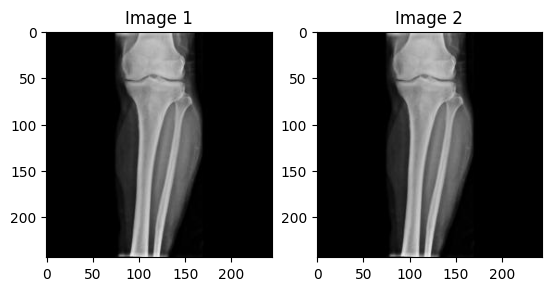

In [9]:
# temp[0][0].min()
import matplotlib.pyplot as plt
index += 1
# print(temp[1][index],temp[2][index])
print((temp[0][index].numpy()*255).max().astype(np.uint8))

fig, axs = plt.subplots(1, 2)

print(str(temp[2][index]))
# Plot the first image
axs[0].imshow(((temp[0][index]+1)/2).permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

In [66]:
# import models here
import sklearn.metrics
from resnetModel import ResNet50
import sklearn
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
import cv2
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns
from abc import ABC

#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY

class ExperimentModel(L.LightningModule,ABC):

    existingModels = []

    def __init__(self) -> None:
        ExperimentModel.existingModels.append(self)
        super().__init__()

        #init the models here in a subclass

        self.num_class = 3
        self.classWeight = torch.tensor([0.204, 0.052, 0.175],device='cuda')

        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        self.bestValPreds = [[]]
        self.bestValLabels = [[]]
        self.bestValScore = []

        self.dump = []

    @abstractmethod
    def forward():
        pass
    
    def training_step(self,batch):
        data,label,path = batch
        output = self(data)
        self.dump.append([path,label])
        loss = F.cross_entropy(output,label,weight=self.classWeight)
        # print(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", multiclass_accuracy(output.argmax(1),label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label,path = batch
        output = self(data)

        preds = output.argmax(1)
        loss = F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(preds)
        self.valScore.append(sklearn.metrics.f1_score(label.cpu(),preds.cpu(),labels = range(self.num_class),average = 'macro'))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", sklearn.metrics.f1_score(label.cpu(),preds.cpu(),labels = range(self.num_class),average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", multiclass_accuracy(preds,label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    # def on_validation_epoch_end(self) -> None:
    #     if len(self.valScore) == 2:
    #         return None
        
    #     accuracy = torch.stack(self.valScore).mean()
    #     self.bestValScore.append(accuracy)
    #     self.bestValPreds.append(torch.cat(self.valPreds))
    #     self.bestValLabels.append(torch.cat(self.valLabels))
    #     print(f"preds: {torch.cat(self.valPreds)}\n labels: {torch.cat(self.valLabels)}")
    #     # self.log("val_acc_F1", multiclass_f1_score(torch.cat(self.valPreds),torch.cat(self.valLabels),num_classes=self.num_class,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True)
       
    #     # print(f"\n Validation accuracy: {accuracy}")
    #     # print(f"bestValScore: {self.bestValScore}")
    #     self.valPreds = []
    #     self.valLabels = []
    #     self.valScore = []

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

In [74]:
import functools
import re

class GradCamTrack(ExperimentModel): #Class for GradCam visualization, should be subclassed by the model to be visualized with a new init and a forward + hook
    
    def __init__(self,) -> None:
        super().__init__()
        
        self.gradients = None
        self.cachedActivation = None

    # cachedActivation is no longer needed, but kept for legacy purposes
    def activations_hook(self, grad, imageActivation = None):
        if imageActivation != None:
            self.cachedActivation = imageActivation
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)
     
    # Runs CAM and overlays the image
    # this is the function to call for visualization
    def visualize(self,dataloader:torch.utils.data.dataloader.DataLoader): #TODO FIX THIS for generalization
        out,path,label = self.CAM(dataloader)
        for i in range(len(out)):
            self.visualizeAndWrite(out[i],path[i],label[i])
        return out,path
    
    # Visualizes the Gradients of the last conv layer of model
    # can take in torch dataloader or list of [img],[label],[path]
    def CAM(self,dataloader:torch.utils.data.dataloader.DataLoader):
        self.eval()
        if isinstance(dataloader,torch.utils.data.dataloader.DataLoader):
            img,label,path = next(iter(dataloader))

        else:
            img,label,path = dataloader

        img = img.to(device = torch.device('cuda'))
        heatmapList = []
        for i in range(len(img)):
            pred = self(torch.unsqueeze(img[i],0))
            # get the gradient of the output with respect to the parameters of the model
            pred[:, label[i].item()].backward()

            # pull the gradients out of the model
            gradients = self.get_activations_gradient()

            # pool the gradients across the channels
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

            # get the activations of the last convolutional layer
            if self.cachedActivation != None:
                activations = self.cachedActivation.detach()
                print(activations - self.get_activations(torch.unsqueeze(img[i],0)).detach())
                print(f"cached:{activations.shape}")
            else:
                activations = self.get_activations(torch.unsqueeze(img[i],0)).detach() # DONT forget to apply image changes here too
                print(f"not cached:{activations.shape}")
            # weight the channels by corresponding gradients
            print(f"pooled shape: {pooled_gradients.shape}")
            for j in range(pooled_gradients.shape[0]):
                activations[:, j, :, :] *= pooled_gradients[j]
                
            # average the channels of the activations
            heatmap = torch.mean(activations, dim=1).squeeze()
            print(heatmap.shape)

            # relu on top of the heatmap
            # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
            heatmap = np.maximum(heatmap.detach().cpu(), 0)

            # normalize the heatmap
            heatmap /= torch.max(heatmap)

            # draw the heatmap
            heatmapList.append(heatmap)
            print(heatmap.shape)

        return heatmapList,path,label
    

    #writes files to disk for visualization, format: model_epoch_label_pred/image.jpg
    def visualizeAndWrite(self,out:torch.tensor,path:str,label:str,epoch=False): #TODO Implement this with tensorboard
        if not epoch:
            epoch = self.current_epoch

        labelDict = {0:'N',1:'OP',2:'OS'}
            
        img = cv2.imread(path)
        heatmap = cv2.resize(out.numpy(), (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + img
        match = re.findall(r"[A-Z,a-z]*",path)[-1]
        path = re.sub(r"[A-Z,a-z]*",labelDict[match],path)
        cv2.imwrite(rf'./visualizations/gradCam/{self.__class__.__name__}_{epoch}__{str(label)}_{path.split(r"/")[-1]}', superimposed_img)


class VGGModel(GradCamTrack):
    def __init__(self,vgg:torchvision.models.vgg.VGG) -> None:
        super().__init__()
        self.features_conv = vgg.features[:36]
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = vgg.classifier
        self.classifier[6] = torch.nn.Linear(4096,self.num_class)


    def forward(self,inTensor):
        x = self.features_conv(inTensor)
        
        # # register the hook
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.flatten(1,-1)
        x = self.classifier(x)
        return x


import resnetModel

class ResnetModel(GradCamTrack):
    def __init__(self,resnet:torchvision.models.resnet.ResNet) -> None:
        super().__init__()
        self.features_conv = torch.nn.Sequential(*[x for x in resnet.children()][:-2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(2048, self.num_class)
        # self.model.layer4[2] = resnetModel.CustBottleneck(2048,512,self.activations_hook)
        # self.model.fc = torch.nn.Linear(2048,3)
        
    def forward(self,inTensor:torch.tensor):
        x = self.features_conv(inTensor)
        
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


In [68]:
import torch
model = torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True)
resnet50 = ResnetModel(model)
resnet50

Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0


ResnetModel(
  (features_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [ ]:
vgg19 = VGGModel(torchvision.models.vgg19(pretrained=True))

In [69]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
for x in ExperimentModel.existingModels:
    print(x.__class__.__name__)
    gc.collect()
    torch.cuda.empty_cache()
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',  # Metric to monitor
    #     patience=5000,          # Number of epochs with no improvement after which training will be stopped
    #     verbose=False,        # Verbosity mode
    #     mode='min'           # Mode can be 'min', 'max', or 'auto'
    # )

    logger = TensorBoardLogger("tb_logs", name=f"{x.__class__.__name__}")
    

    trainer = L.Trainer(max_epochs = 10,accelerator='gpu', devices='auto', precision='16-mixed',logger=logger)
    trainer.fit(model=x,train_dataloaders=trainLoader,val_dataloaders=valLoader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ResnetModel



  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | features_conv | Sequential        | 23.5 M | train
1 | avgpool       | AdaptiveAvgPool2d | 0      | train
2 | fc            | Linear            | 6.1 K  | train
------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [72]:
import torch
model = torch.hub.load('pytorch/vision:v0.19.0', 'resnet50', pretrained=True)
resnetPath = r'C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\tb_logs\ResnetModel\version_20\checkpoints'
resnet50 = ResnetModel.load_from_checkpoint('\\'.join([resnetPath,os.listdir(resnetPath)[-1]]),resnet = model)
torch.cuda.empty_cache()
out,label = resnet50.visualize(valLoader)

Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0


not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached:torch.Size([1, 2048, 8, 8])
pooled shape: torch.Size([2048])
torch.Size([8, 8])
torch.Size([8, 8])
not cached

tensor([[[[ 2.9179e-03,  0.0000e+00,  2.6086e-03,  ...,  1.9394e-03,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-4.6089e-03,  0.0000e+00, -7.6998e-03,  ..., -6.2716e-03,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 4.1731e-04,  0.0000e+00, -1.8500e-03,  ..., -5.6967e-04,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00, -5.4876e-02]],

         [[-3.1212e-03,  0.0000e+00,  0.0000e+00,  ...,  1.3000e-03,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-1.8807e-03,  0.0000e+00, -5.8599e-03,  ...,  3.1716e-03,
            0.0000e+00,  0.0000e+00],
          ...,
     

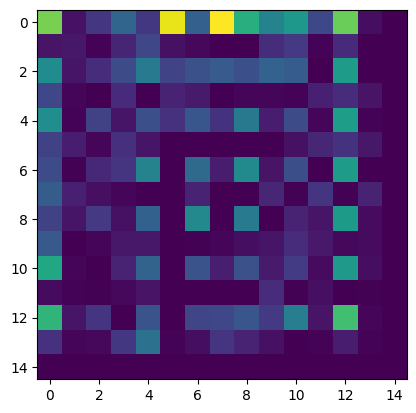

In [24]:
torch.cuda.empty_cache()
model = VGGModel.load_from_checkpoint(r'tb_logs\VGGModel\version_26\checkpoints\epoch=19-step=720.ckpt',vgg = torchvision.models.vgg19(pretrained=False))
outvgg,path = model.visualize(valLoader)

plt.imshow(outvgg[0])

In [ ]:
model

In [ ]:
out[1][0].split('/')[-1]

In [ ]:
ExperimentModel.existingModels[0].valPreds

In [ ]:
img,_,_ = next(iter(trainLoader))

In [ ]:
torch.unsqueeze(img[0],0).shape

In [ ]:
resnet50.eval()
img,lab,path = next(iter(trainLoader))
pred = resnet50(torch.unsqueeze(img[0],0))
print(pred)
# get the gradient of the output with respect to the parameters of the model
pred[:, 1].backward()

# pull the gradients out of the model
gradients = resnet50.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resnet50.get_activations(torch.unsqueeze(img[0],0)).detach()
print(activations.shape)

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

In [ ]:
import cv2
img = cv2.imread(out[1][0])
heatmap = cv2.resize(out[0][0].numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./test.jpg', superimposed_img)

In [ ]:
out[1][0]

In [ ]:
cv2.imwrite("img.jpg",superimposed_img)

In [ ]:
pred.argmax(dim=1)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.19.0', "vgg19",{"num_classes":3}, pretrained=True, )
model.classifier[6] = torch.nn.Linear(4096,3)
model

In [55]:
model = resnet50

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
# Define the loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.204, 0.052, 0.175],device='cuda'))

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device to GPU if available
device = torch.device("cuda")

# Move the model to the device
model = model.to(device)

# Set the model to training mode
model.train()

num_epochs = 25

accHistory = []
lossHistory = []
valAccHistory = []
valLabs = []
valPreds = []
print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = []
    
    # Iterate over the training dataset
    for inputs, labels, _ in trainLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs.float())
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)
        running_accuracy.append(accuracy)
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(trainLoader)}")
    print(F"Accuracy: {sum(running_accuracy)/len(running_accuracy)}")
    accHistory.append(sum(running_accuracy)/len(running_accuracy))
    lossHistory.append(running_loss / len(trainLoader))

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        
        runningValAccHistory = []
        runningValLabs = []
        runningValPreds = []
        for inputs, labels, _ in valLoader:

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs.float())

            # Compute the loss
            loss = criterion(outputs, labels)

            # Compute the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Compute the accuracy
            accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

            runningValAccHistory.append(accuracy)
            runningValLabs.append(labels)
            runningValPreds.append(predicted_labels)

        # print(f"Validation Loss: {loss.item()}")
        valPreds.append(runningValPreds)
        valLabs.append(runningValLabs)
        print(f"Validation Accuracy: {sum(runningValAccHistory)/len(valLoader)}")
        valAccHistory.append(sum(runningValAccHistory)/len(valLoader))

Starting training...


ValueError: Input dimension should be at least 3

In [ ]:
import seaborn as sns
idx = 25
predsTest = torch.cat(valPreds[idx-1])
labelsTest = torch.cat(valLabs[idx-1])
print(valAccHistory[idx-1])
print(classification_report(predsTest.cpu(),labelsTest.cpu()))
cm= confusion_matrix(predsTest.cpu(),labelsTest.cpu(),normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
labelsTest

In [ ]:
plt.plot(valAccHistory)

In [ ]:
input , label, _ = next(iter(valLoader))
# Move the inputs and labels to the device
inputs = inputs.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(inputs)
predicted_labels = torch.argmax(outputs, dim=1)
print(predicted_labels)


In [ ]:
import seaborn as sns
import pandas as pd

# Create a dataframe with the data
df = pd.DataFrame({'Epoch': range(len(accHistory)), 'Accuracy': accHistory, 'Loss': lossHistory, 'Validation Accuracy': valAccHistory})

# Create the line plot
sns.relplot(data=df, x='Epoch', y='Accuracy', kind='line')
sns.relplot(data=df, x='Epoch', y='Loss', kind='line')
sns.relplot(data=df, x='Epoch', y='Validation Accuracy', kind='line')

In [ ]:
torch.save(model.state_dict(), "resnetClassic.pth")

In [ ]:
outputs = []
label = []
import gc
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    for inputs, labels, _ in valLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        label = labels
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Compute the accuracy
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

In [ ]:
print(outputs.argmax(1))
print(label)